# Tencent AI Lab DrugOOD Demo

Welcome to DrugOOD! This is the official tutorial for using from drugood. In this tutorial, you will get the following:

- Curate a new OOD dataset from the ChEMBL database.
- Train an OOD algorithm with the generated dataset.

Let's get started!

https://drug.ai.tencent.com/drugood/

## Environment Preparing

### Conda Env Installation

Firstly, make sure that you have installed the env following the readme.md.

You can install the conda environment using the drugood.yaml file provided:

In [ ]:
!git clone https://github.com/tencent-ailab/DrugOOD.git
!cd DrugOOD
!conda env create --name drugood --file=drugood.yaml
!conda activate drugood

### DrugOOD Installation

Then you can install the drugood package. Make sure that you are in the code root folder: 

In [ ]:
%cd ../
%pwd

In [ ]:
!python setup.py  install 

## DrugOOD Dataset Curator

DrugOOD benchmark has provided 96 bulit-in datasets. You can coustom your own ood dataset by using the dataset curator. The dataset curator currently focuses on generating datasets from the deposition website CHEMBL.

It supports the following two tasks:
- Ligand Based Affinity Prediction (LBAP for short).
- Stucture Based Affinity Prediction (SBAP for short).

For domains, it supports the following 5 choices.

- Assay.
- Scaffold.
- Size.
- Protein. (only for SBAP task)
- Protein Family. (only for SBAP task)

For noise annotations, it supports the following three noise levels, together with a full set. Datasets with different noises are implemented by filters with different levels of strictness.

- Core.
- Refined.
- General.

At the same time, due to the inconvenient conversion between different measurement type (E.g. IC50, EC50, Ki, Potency), user can specify the targeted measurement type when generating the dataset.

### Chembl Database Download
To custom a new dataset using DrugOOD dataset curator, let's first download the chembl29 database in the sqllite format.  Assume that you put it in you local folder: `CHEMBL_SQLLITE/`


In [ ]:
!wget http://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_29/chembl_29_sqlite.tar.gz
!tar -xvf chembl_29_sqlite.tar.gz > CHEMBL_SQLLITE/

--2022-02-08 14:33:37--  http://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_29/chembl_29_sqlite.tar.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4218778217 (3.9G) [application/octet-stream]
Saving to: 'chembl_29_sqlite.tar.gz'

 0% [                                       ] 14,605,509   112KB/s  eta 20h 34m

In [ ]:
# Check the directory structure of the downloaded 
# Install tree first
!apt-get -q install tree
!tree CHEMBL_SQLLITE/chembl_29_sqlite

### Modify the curation config
In the next step, we need to modify the config file for the data curator. To accelerate the process, we modify the configuration based on a built-in dataset's config.


In [ ]:
%cd demo

In [10]:
from mmcv import Config
cfg = Config.fromfile('../configs/curators/lbap_core_ec50_assay.py')

In [11]:
print(f'Built-in Config:\n{cfg.pretty_text}')

Built-in Config:
path = dict(
    task=dict(type='lbap', subset='lbap_core_ec50_assay'),
    source_root=
    '/apdcephfs/share_1364275/xluzhang/chembl_29_sqlite/chembl_29.db',
    target_root='data/')
uncertainty = dict(delta=dict({'<': -1, '<=': -1, '>': 1, '>=': 1}))
classification_threshold = dict(lower_bound=4, upper_bound=6, fix_value=5)
fractions = dict(
    train_fraction_ood=0.6,
    val_fraction_ood=0.2,
    iid_train_sample_fractions=0.6,
    iid_val_sample_fractions=0.2)
noise_filter = dict(
    assay=dict(
        measurement_type=['EC50'],
        assay_value_units=['nM', 'uM'],
        molecules_number=[50, 3000],
        confidence_score=9),
    sample=dict(
        filter_none=[],
        smile_exist=[],
        smile_legal=[],
        value_relation=['=', '~']))
domain = dict(
    domain_generate_field='assay_id',
    domain_name='assay',
    sort_func='domain_capacity',
    sort_order='descend',
    protein_family_level=1)



We modify some values to customize the dataset we need. For example, we want to filter out data with molecule numbers outside of [50, 100].

In [12]:
cfg.noise_filter.assay.molecules_number=[50, 100]
cfg.path.task.subset ="lbap_core_ec50_assay_custom"
print(f'Built-in Config:\n{cfg.pretty_text}')

Built-in Config:
path = dict(
    task=dict(type='lbap', subset='lbap_core_ec50_assay_custom'),
    source_root=
    '/apdcephfs/share_1364275/xluzhang/chembl_29_sqlite/chembl_29.db',
    target_root='data/')
uncertainty = dict(delta=dict({'<': -1, '<=': -1, '>': 1, '>=': 1}))
classification_threshold = dict(lower_bound=4, upper_bound=6, fix_value=5)
fractions = dict(
    train_fraction_ood=0.6,
    val_fraction_ood=0.2,
    iid_train_sample_fractions=0.6,
    iid_val_sample_fractions=0.2)
noise_filter = dict(
    assay=dict(
        measurement_type=['EC50'],
        assay_value_units=['nM', 'uM'],
        molecules_number=[50, 100],
        confidence_score=9),
    sample=dict(
        filter_none=[],
        smile_exist=[],
        smile_legal=[],
        value_relation=['=', '~']))
domain = dict(
    domain_generate_field='assay_id',
    domain_name='assay',
    sort_func='domain_capacity',
    sort_order='descend',
    protein_family_level=1)



### Generating new ood dataset

Now, lets's generate the new ood dataset. It may take some time the first time running, cause 
it will cache the processed SQL data the first time. The second time running it will automacally load 
the cached data.  


In [15]:
from drugood.apis.curate import curate_data

curate_data(cfg)

Using backend: pytorch


Curator Config:
path = dict(
    task=dict(type='lbap', subset='lbap_core_ec50_assay_custom'),
    source_root=
    '/apdcephfs/share_1364275/xluzhang/chembl_29_sqlite/chembl_29.db',
    target_root='data/')
uncertainty = dict(delta=dict({'<': -1, '<=': -1, '>': 1, '>=': 1}))
classification_threshold = dict(lower_bound=4, upper_bound=6, fix_value=5)
fractions = dict(
    train_fraction_ood=0.6,
    val_fraction_ood=0.2,
    iid_train_sample_fractions=0.6,
    iid_val_sample_fractions=0.2)
noise_filter = dict(
    assay=dict(
        measurement_type=['EC50'],
        assay_value_units=['nM', 'uM'],
        molecules_number=[50, 100],
        confidence_score=9),
    sample=dict(
        filter_none=[],
        smile_exist=[],
        smile_legal=[],
        value_relation=['=', '~']))
domain = dict(
    domain_generate_field='assay_id',
    domain_name='assay',
    sort_func='domain_capacity',
    sort_order='descend',
    protein_family_level=1)

--------------------------------------

Uncertainty Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 8255/8255 [00:00<00:00, 2500829.15it/s]


data saved to data/lbap_core_ec50_assay_custom.json
------------------------------------------------------------
+-------------------------------------------+
|     Statistics of curated ood dataset     |
+----------+---------------+----------------+
|  split   | domain number | sample number  |
+----------+---------------+----------------+
|  train   |       55      |      2039      |
| iid_val  |       55      |      665       |
| ood_val  |       26      |      1130      |
| iid_test |       55      |      730       |
| ood_test |       60      |      1113      |
+----------+---------------+----------------+


The curated dataset will be stored in the `target_root` dir, which is "data" here. let's check the directory structure of the result. 

In [17]:
!tree data/

data/
`-- lbap_core_ec50_assay_custom.json

0 directories, 1 file


Let's visulize some example from this new dataset

In [19]:
import mmcv
data = mmcv.load("data/lbap_core_ec50_assay_custom.json")
train = data["split"]["train"]
ood_test = data["split"]["ood_test"]

In [20]:
ood_test

[{'smiles': 'COCCNCCC(=O)N[C@H]1c2ccccc2C[C@@H]1NC(=O)c1cc2ccccc2n1C',
  'reg_label': 6.8,
  'assay_id': 1722251,
  'cls_label': 1,
  'domain_id': 119},
 {'smiles': 'CN(C)CCC(=O)N[C@H]1c2ccccc2C[C@@H]1NC(=O)c1cc2cc(F)c(F)cc2[nH]1',
  'reg_label': 7.48,
  'assay_id': 1722251,
  'cls_label': 1,
  'domain_id': 119},
 {'smiles': 'O=C(N[C@H]1Cc2ccccc2[C@@H]1NC(=O)[C@H]1CCNC1)c1cc2cc(F)ccc2[nH]1',
  'reg_label': 7.3149999999999995,
  'assay_id': 1722251,
  'cls_label': 1,
  'domain_id': 119},
 {'smiles': 'Cc1ccc2[nH]c(C(=O)N[C@H]3Cc4ccccc4[C@@H]3NC(=O)CCN(C)C)cc2c1',
  'reg_label': 7.6899999999999995,
  'assay_id': 1722251,
  'cls_label': 1,
  'domain_id': 119},
 {'smiles': 'Cc1ccc2[nH]c(C(=O)N[C@@H]3Cc4ccccc4[C@H]3NC(=O)CCN(C)C)cc2c1',
  'reg_label': 6.625,
  'assay_id': 1722251,
  'cls_label': 1,
  'domain_id': 119},
 {'smiles': 'Cc1ccc2[nH]c(C(=O)N[C@H]3Cc4ccccc4[C@H]3NC(=O)CCN(C)C)cc2c1',
  'reg_label': 7.0,
  'assay_id': 1722251,
  'cls_label': 1,
  'domain_id': 119},
 {'smiles': 'Cc1cc

In [21]:
import io
from PIL import Image
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

import random
import numpy as np
import matplotlib.pyplot as plt

# smiles = 'CCCCNc1nc(NCC2CC2)nc(N2CCC[C@@H]2CNS(=O)(=O)c2ccc(CCC)cc2)n1' 
# m = Chem.MolFromSmiles(smiles)

def moltosvg(mol, molSize = (500,500), kekulize = True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DCairo(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    bts = drawer.GetDrawingText()
    im = Image.open(io.BytesIO(bts))
    return im

def display_multiple_img(images, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows,ncols=cols, figsize=(10,5) )
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title])
        ax.ravel()[ind].set_title(title)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()
    
# moltosvg(m)

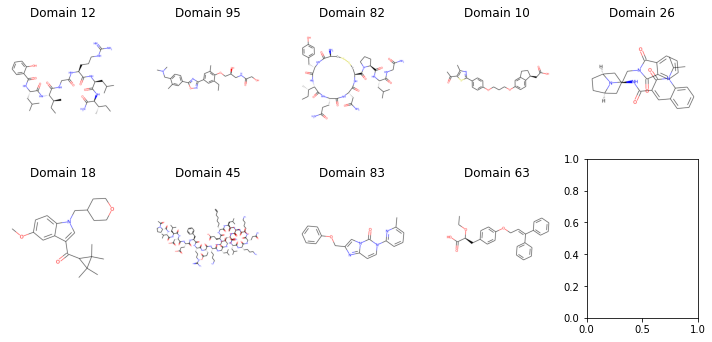

In [22]:
# train examples:
train_example = random.sample(train, 5)
total_images = 5
images = {"Domain {}".format(item["domain_id"]) : moltosvg(Chem.MolFromSmiles(item["smiles"])) for i, item in enumerate(train_example)}
# ood examples:
ood_test_example = random.sample(ood_test, 5)
total_images = 5
images.update({"Domain {}".format(item["domain_id"]) : moltosvg(Chem.MolFromSmiles(item["smiles"])) for i, item in enumerate(ood_test_example)})
display_multiple_img(images, 2, 5)

### Train an OOD algorithm
Finally, let us initialize the dataset and algorithm, then train a new model! For convenience, we modify the settings based on a built-in algorithm config.

In [23]:
from mmcv import Config
from drugood.apis import set_random_seed

cfg = Config.fromfile('../configs/algorithms/erm/lbap_core_ec50_assay_erm.py')

ann_file = 'data/lbap_core_ec50_assay_custom.json'
cfg.data.train.ann_file = ann_file
cfg.data.ood_val.ann_file= ann_file
cfg.data.iid_val.ann_file= ann_file
cfg.data.ood_test.ann_file= ann_file
cfg.data.iid_test.ann_file= ann_file

cfg.runner.max_epochs=5

# Set seed thus the results are more reproducible
cfg.seed = 0
cfg.gpu_ids = range(1)

cfg.work_dir = "work_dirs/lbap_core_ec50_assay_custom"

print(f'Config:\n{cfg.pretty_text}')

Config:
optimizer = dict(type='AdamW', lr=0.0001, weight_decay=0)
optimizer_config = dict(grad_clip=None)
lr_config = dict(policy='fixed')
runner = dict(type='EpochBasedRunner', max_epochs=5)
evaluation = dict(metric=['accuracy', 'auc'])
checkpoint_config = dict(interval=5)
log_config = dict(
    interval=5,
    hooks=[dict(type='TextLoggerHook'),
           dict(type='TensorboardLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]
train_pipeline = [
    dict(type='SmileToGraph', keys=['input']),
    dict(type='Collect', keys=['input', 'gt_label', 'group'])
]
test_pipeline = [
    dict(type='SmileToGraph', keys=['input']),
    dict(type='Collect', keys=['input', 'gt_label', 'group'])
]
dataset_type = 'LBAPDataset'
ann_file = 'data/lbap_core_ec50_assay.json'
data = dict(
    samples_per_gpu=128,
    workers_per_gpu=4,
    train=dict(
        split='train',
        type='LBAPDataset',
        ann_file='data/lba

In [24]:
import mmcv
import os.path as osp
from drugood.apis import set_random_seed
from drugood.datasets import build_dataset
from drugood.models import build_model
from drugood.apis import train_model

# Set seed
set_random_seed(cfg.seed, deterministic=False)

# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the ood model
model = build_model(cfg.model)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2022-03-19 18:21:04,315 - drugood - INFO - start runner...
2022-03-19 18:21:04,316 - drugood - INFO - Start running, host: root@VM-121-51-centos, work_dir: /apdcephfs/private_yataobian/dl-research/graph-ood-benchmark/demo/work_dirs/lbap_core_ec50_assay_custom
2022-03-19 18:21:04,317 - drugood - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) FixedLrUpdaterHook                 
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(NORMAL      ) EvalHook                           
(NORMAL      ) EvalHook                           
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) TensorboardLoggerHook              
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) FixedLrUpdaterHook                 
(NORMAL      ) EvalHook                           
(NORMAL      ) EvalHook                           
(NORMAL      ) EvalHook           

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1130/1130, 865.8 task/s, elapsed: 1s, ETA:     0s

2022-03-19 18:21:10,558 - drugood - INFO - Now best checkpoint is saved as best_ood_val:accuracy_epoch_1.pth.
2022-03-19 18:21:10,559 - drugood - INFO - Best ood_val:accuracy is 16.5487 at 1 epoch.


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 730/730, 468.3 task/s, elapsed: 2s, ETA:     0s[                                                  ] 0/1113, elapsed: 0s, ETA:[                                                  ] 0/730, elapsed: 0s, ETA:

2022-03-19 18:21:15,372 - drugood - INFO - Epoch(val) [1][6]	ood_val:accuracy: 16.5487, ood_val:auc: 40.8003, iid_val:accuracy: 15.1880, iid_val:auc: 42.5734, ood_test:accuracy: 9.3441, ood_test:auc: 31.6016, iid_test:accuracy: 13.2877, iid_test:auc: 39.1371
2022-03-19 18:21:18,547 - drugood - INFO - Epoch [2][5/16]	lr: 1.000e-04, eta: 0:00:21, time: 0.629, data_time: 0.583, memory: 264, crossentropy_loss: 1.8186, loss: 1.8186
2022-03-19 18:21:18,934 - drugood - INFO - Epoch [2][10/16]	lr: 1.000e-04, eta: 0:00:17, time: 0.079, data_time: 0.036, memory: 264, crossentropy_loss: 1.4054, loss: 1.4054
2022-03-19 18:21:19,230 - drugood - INFO - Epoch [2][15/16]	lr: 1.000e-04, eta: 0:00:13, time: 0.059, data_time: 0.022, memory: 264, crossentropy_loss: 1.1940, loss: 1.1940


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1130/1130, 880.5 task/s, elapsed: 1s, ETA:     0s

2022-03-19 18:21:20,670 - drugood - INFO - The previous best checkpoint /apdcephfs/private_yataobian/dl-research/graph-ood-benchmark/demo/work_dirs/lbap_core_ec50_assay_custom/best_ood_val:accuracy_epoch_1.pth was removed
2022-03-19 18:21:20,693 - drugood - INFO - Now best checkpoint is saved as best_ood_val:accuracy_epoch_2.pth.
2022-03-19 18:21:20,694 - drugood - INFO - Best ood_val:accuracy is 50.6195 at 2 epoch.


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 730/730, 556.8 task/s, elapsed: 1s, ETA:     0s[                                                  ] 0/1113, elapsed: 0s, ETA:[                                                  ] 0/730, elapsed: 0s, ETA:

2022-03-19 18:21:25,246 - drugood - INFO - Epoch(val) [2][6]	ood_val:accuracy: 50.6195, ood_val:auc: 51.6418, iid_val:accuracy: 27.6692, iid_val:auc: 44.7544, ood_test:accuracy: 27.5831, ood_test:auc: 64.2833, iid_test:accuracy: 30.2740, iid_test:auc: 48.1984
2022-03-19 18:21:28,662 - drugood - INFO - Epoch [3][5/16]	lr: 1.000e-04, eta: 0:00:13, time: 0.677, data_time: 0.626, memory: 264, crossentropy_loss: 1.1240, loss: 1.1240
2022-03-19 18:21:29,069 - drugood - INFO - Epoch [3][10/16]	lr: 1.000e-04, eta: 0:00:11, time: 0.083, data_time: 0.043, memory: 264, crossentropy_loss: 1.0169, loss: 1.0169
2022-03-19 18:21:29,359 - drugood - INFO - Epoch [3][15/16]	lr: 1.000e-04, eta: 0:00:08, time: 0.058, data_time: 0.021, memory: 264, crossentropy_loss: 0.8965, loss: 0.8965


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1130/1130, 869.0 task/s, elapsed: 1s, ETA:     0s

2022-03-19 18:21:30,846 - drugood - INFO - The previous best checkpoint /apdcephfs/private_yataobian/dl-research/graph-ood-benchmark/demo/work_dirs/lbap_core_ec50_assay_custom/best_ood_val:accuracy_epoch_2.pth was removed
2022-03-19 18:21:30,870 - drugood - INFO - Now best checkpoint is saved as best_ood_val:accuracy_epoch_3.pth.
2022-03-19 18:21:30,870 - drugood - INFO - Best ood_val:accuracy is 83.2743 at 3 epoch.


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 730/730, 582.1 task/s, elapsed: 1s, ETA:     0s[                                                  ] 0/1113, elapsed: 0s, ETA:[                                                  ] 0/730, elapsed: 0s, ETA:

2022-03-19 18:21:35,398 - drugood - INFO - Epoch(val) [3][6]	ood_val:accuracy: 83.2743, ood_val:auc: 60.7622, iid_val:accuracy: 67.9699, iid_val:auc: 66.3614, ood_test:accuracy: 75.7412, ood_test:auc: 65.9827, iid_test:accuracy: 68.4932, iid_test:auc: 65.7511
2022-03-19 18:21:38,556 - drugood - INFO - Epoch [4][5/16]	lr: 1.000e-04, eta: 0:00:08, time: 0.625, data_time: 0.576, memory: 264, crossentropy_loss: 0.8604, loss: 0.8604
2022-03-19 18:21:38,942 - drugood - INFO - Epoch [4][10/16]	lr: 1.000e-04, eta: 0:00:06, time: 0.079, data_time: 0.042, memory: 264, crossentropy_loss: 0.7079, loss: 0.7079
2022-03-19 18:21:39,264 - drugood - INFO - Epoch [4][15/16]	lr: 1.000e-04, eta: 0:00:04, time: 0.064, data_time: 0.031, memory: 264, crossentropy_loss: 0.7459, loss: 0.7459


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1130/1130, 813.4 task/s, elapsed: 1s, ETA:     0s

2022-03-19 18:21:40,811 - drugood - INFO - The previous best checkpoint /apdcephfs/private_yataobian/dl-research/graph-ood-benchmark/demo/work_dirs/lbap_core_ec50_assay_custom/best_ood_val:accuracy_epoch_3.pth was removed
2022-03-19 18:21:40,836 - drugood - INFO - Now best checkpoint is saved as best_ood_val:accuracy_epoch_4.pth.
2022-03-19 18:21:40,836 - drugood - INFO - Best ood_val:accuracy is 86.9912 at 4 epoch.


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 730/730, 502.2 task/s, elapsed: 1s, ETA:     0s[                                                  ] 0/1113, elapsed: 0s, ETA:[                                                  ] 0/730, elapsed: 0s, ETA:

2022-03-19 18:21:45,245 - drugood - INFO - Epoch(val) [4][6]	ood_val:accuracy: 86.9912, ood_val:auc: 63.1814, iid_val:accuracy: 87.6692, iid_val:auc: 78.2343, ood_test:accuracy: 84.3666, ood_test:auc: 64.0107, iid_test:accuracy: 88.4932, iid_test:auc: 84.2833
2022-03-19 18:21:48,912 - drugood - INFO - Epoch [5][5/16]	lr: 1.000e-04, eta: 0:00:03, time: 0.729, data_time: 0.686, memory: 264, crossentropy_loss: 0.6584, loss: 0.6584
2022-03-19 18:21:49,241 - drugood - INFO - Epoch [5][10/16]	lr: 1.000e-04, eta: 0:00:01, time: 0.065, data_time: 0.028, memory: 264, crossentropy_loss: 0.6552, loss: 0.6552
2022-03-19 18:21:49,604 - drugood - INFO - Epoch [5][15/16]	lr: 1.000e-04, eta: 0:00:00, time: 0.074, data_time: 0.036, memory: 264, crossentropy_loss: 0.6526, loss: 0.6526
2022-03-19 18:21:49,696 - drugood - INFO - Saving checkpoint at 5 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 730/730, 507.8 task/s, elapsed: 1s, ETA:     0s[                                                  ] 0/665, elapsed: 0s, ETA:[                                                  ] 0/1113, elapsed: 0s, ETA:[                                                  ] 0/730, elapsed: 0s, ETA:

2022-03-19 18:21:55,655 - drugood - INFO - Epoch(val) [5][6]	ood_val:accuracy: 59.2920, ood_val:auc: 60.0340, iid_val:accuracy: 81.8045, iid_val:auc: 77.0354, ood_test:accuracy: 68.3738, ood_test:auc: 65.4762, iid_test:accuracy: 84.7945, iid_test:auc: 86.6539
